In [30]:
import os
import librosa  
#import librosa.display
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, fft
from tqdm import tqdm 
import umap.umap_ as umap

c:\Users\ylfgh\Documents\Python_Projects\MusicClassification2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
music_genres_dir = '..\\..\\data\\raw\\Data\\genres_original'
!dir $music_genres_dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is 8AF1-79EF

 Directory of c:\Users\ylfgh\Documents\Python_Projects\MusicClassification2\data\raw\Data\genres_original

02/07/2025  05:47 PM    <DIR>          .
02/07/2025  05:47 PM    <DIR>          ..
02/07/2025  05:46 PM    <DIR>          blues
02/07/2025  05:46 PM    <DIR>          classical
02/07/2025  05:46 PM    <DIR>          country
02/07/2025  05:46 PM    <DIR>          disco
02/07/2025  05:46 PM    <DIR>          hiphop
02/07/2025  05:47 PM    <DIR>          jazz
02/07/2025  05:47 PM    <DIR>          metal
02/07/2025  05:47 PM    <DIR>          pop
02/07/2025  05:47 PM    <DIR>          reggae
02/07/2025  05:47 PM    <DIR>          rock
               0 File(s)              0 bytes
              12 Dir(s)  161,436,864,512 bytes free


In [3]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [4]:
audio_files = []
labels=[]

for genre in genres :
    genre_path = os.path.join(music_genres_dir, genre)
    for audio_file in tqdm(os.listdir(genre_path)):
        if audio_file.endswith('.wav'):
            audio_files.append(os.path.join(genre_path, audio_file))
            labels.append(genre)

print(f"Number of audio files: {len(audio_files)}")
# create a dataframe
df = pd.DataFrame({'filename': audio_files, 'genre': labels})
df.head()

100%|██████████| 100/100 [00:00<?, ?it/s]

Number of audio files: 1000


,filename,genre
0,..\..\data\raw\Data\genres_original\blues\blue...,blues
1,..\..\data\raw\Data\genres_original\blues\blue...,blues
2,..\..\data\raw\Data\genres_original\blues\blue...,blues
3,..\..\data\raw\Data\genres_original\blues\blue...,blues
4,..\..\data\raw\Data\genres_original\blues\blue...,blues


## Feature exctraction
- **duration**: longueur temporelle du signal audio. 
- **zero_crossing_rate**: nombre de fois qu'un signal change de signe.
- **rms**: Root Mean Square mesure de l'amplitude moyenne du signal, pour les signaux audio, cela correspond à peu près à la puissance du signal.
- **spectral_centroid**: centre de masse du spectre, ou la frequence moyenne pondérée.
- **spectral_rolloff**: frequence en dessous de laquelle se trouve 85% du son.
- **spectral_bandwith**: mesure l'étalement des fréquences autour du centre de masse.

In [5]:
features_list = []

for filename, genre in tqdm(zip(df['filename'], df['genre']), total=len(df)):
    try:
        y, sr = librosa.load(filename)
        duration = librosa.get_duration(y=y, sr=sr)
        num_seconds = int(duration)
        
        for sec in range(num_seconds):
            start_sample = sec * sr
            end_sample = start_sample + sr
            y_segment = y[start_sample:end_sample]
            
            if len(y_segment) < sr:
                continue  # Ignore incomplete last second
            
            features = {
                'filename': filename,
                'genre': genre,
                'second': sec,
                'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y_segment)),
                'rms': np.mean(librosa.feature.rms(y=y_segment)),
                'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=y_segment, sr=sr)),
                'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=y_segment, sr=sr)),
                'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=y_segment, sr=sr)),
                'spectral_contrast': np.mean(librosa.feature.spectral_contrast(y=y_segment, sr=sr)),
                'spectral_flatness': np.mean(librosa.feature.spectral_flatness(y=y_segment)),
                'onset_strength_mean': np.mean(librosa.onset.onset_strength(y=y_segment, sr=sr)),
            }
            
            # Compute tempo
            tempo, _ = librosa.beat.beat_track(y=y_segment, sr=sr)
            features['tempo'] = float(tempo)
            
            # Compute chromagram (mean over time)
            chromagram = librosa.feature.chroma_stft(y=y_segment, sr=sr)
            features['chromagram_mean'] = np.mean(chromagram)
            
            # Compute MFCCs and derivatives
            mfccs = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
            mfccs_delta = librosa.feature.delta(mfccs)
            mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
            
            for i in range(13):
                features[f'mfcc_{i+1}'] = np.mean(mfccs[i])
                features[f'mfcc_delta_{i+1}'] = np.mean(mfccs_delta[i])
                features[f'mfcc_delta2_{i+1}'] = np.mean(mfccs_delta2[i])
            
            features_list.append(features)
    
    except Exception as e:
        print(f"Erreur avec {filename}: {str(e)}")

features_df = pd.DataFrame(features_list)
features_df


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ylfgh\AppData\Local\Temp\ipykernel_9732\1997459905.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features['tempo'] = float(tempo)
 15%|█▌        | 151/1000 [02:07<09:57,  1.42it/s]c:\Users\ylfgh\Documents\Python_Projects\MusicClassification2\.venv\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 55%|█████▌    | 554/1000 [12:11<05:22,  1.38it/s]   C:\Users\ylfgh\AppData\Local\Temp\ipykernel_9732\1997459905.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename)
c:\Users\ylfgh\Documents\Python_Projects\MusicClassification2\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated

Erreur avec ..\..\data\raw\Data\genres_original\jazz\jazz.00054.wav: 


100%|██████████| 1000/1000 [17:30<00:00,  1.05s/it]


,filename,genre,second,zero_crossing_rate,rms,spectral_centroid,spectral_rolloff,spectral_bandwidth,spectral_contrast,spectral_flatness,...,mfcc_delta2_10,mfcc_11,mfcc_delta_11,mfcc_delta2_11,mfcc_12,mfcc_delta_12,mfcc_delta2_12,mfcc_13,mfcc_delta_13,mfcc_delta2_13
0,..\..\data\raw\Data\genres_original\blues\blue...,blues,0,0.077703,0.121084,1687.326771,3654.282449,1948.749895,19.869856,0.004005,...,0.069512,-10.499582,0.002629,0.149546,8.736154,-0.038769,-0.208191,-5.965349,-0.159418,0.032153
1,..\..\data\raw\Data\genres_original\blues\blue...,blues,1,0.074907,0.137397,1784.998030,3701.019287,2037.316008,20.896238,0.003982,...,-0.036927,-11.467854,0.826698,0.068048,12.656390,0.134644,-0.268911,-3.027073,0.022024,0.045641
2,..\..\data\raw\Data\genres_original\blues\blue...,blues,2,0.087902,0.125913,1853.000746,3781.279408,1951.322679,21.010294,0.007861,...,-0.067812,-8.066029,-0.532046,0.030837,10.038571,0.384208,-0.032760,-6.352934,-0.177517,0.295818
3,..\..\data\raw\Data\genres_original\blues\blue...,blues,3,0.099865,0.103725,1928.267598,4006.888650,2028.492700,19.864877,0.007103,...,0.019713,-7.192589,0.142574,0.097916,11.382102,0.040746,-0.229203,-9.254341,-0.144022,-0.139721
4,..\..\data\raw\Data\genres_original\blues\blue...,blues,4,0.066994,0.121812,1666.029409,3624.918990,1949.819291,19.568847,0.003817,...,-0.091183,-12.857110,-0.357001,0.246120,6.844154,-0.070420,-0.207902,-8.717555,0.123634,0.089462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29956,..\..\data\raw\Data\genres_original\rock\rock....,rock,25,0.099509,0.061378,2170.525251,4594.157826,2107.734451,24.214579,0.004530,...,-0.104750,-10.687685,0.051815,0.116979,11.328498,0.132955,0.129520,-17.743227,-0.146661,0.326338
29957,..\..\data\raw\Data\genres_original\rock\rock....,rock,26,0.054144,0.048345,1549.886460,3490.825861,1871.934711,23.880145,0.001363,...,-0.044376,-6.028322,0.364653,0.166257,18.690435,-0.278485,0.048824,-12.806448,-0.109027,0.106553
29958,..\..\data\raw\Data\genres_original\rock\rock....,rock,27,0.038108,0.044864,1083.263245,2353.725919,1569.459739,23.091178,0.000615,...,-0.029001,-3.449104,-0.148850,-0.010814,16.833904,0.055894,-0.132483,-11.137769,-0.057163,0.141052
29959,..\..\data\raw\Data\genres_original\rock\rock....,rock,28,0.063177,0.048148,1614.351774,3564.968595,1928.717568,21.745473,0.002216,...,-0.177957,-2.671310,0.082634,0.202862,17.792366,-0.006626,-0.307975,-14.796105,0.125848,0.300874


In [9]:
print("Shape du DataFrame:", features_df.shape)
features_df.head()

Shape du DataFrame: (29961, 52)


,filename,genre,second,zero_crossing_rate,rms,spectral_centroid,spectral_rolloff,spectral_bandwidth,spectral_contrast,spectral_flatness,...,mfcc_delta2_10,mfcc_11,mfcc_delta_11,mfcc_delta2_11,mfcc_12,mfcc_delta_12,mfcc_delta2_12,mfcc_13,mfcc_delta_13,mfcc_delta2_13
0,..\..\data\raw\Data\genres_original\blues\blue...,blues,0,0.077703,0.121084,1687.326771,3654.282449,1948.749895,19.869856,0.004005,...,0.069512,-10.499582,0.002629,0.149546,8.736154,-0.038769,-0.208191,-5.965349,-0.159418,0.032153
1,..\..\data\raw\Data\genres_original\blues\blue...,blues,1,0.074907,0.137397,1784.998030,3701.019287,2037.316008,20.896238,0.003982,...,-0.036927,-11.467854,0.826698,0.068048,12.656390,0.134644,-0.268911,-3.027073,0.022024,0.045641
2,..\..\data\raw\Data\genres_original\blues\blue...,blues,2,0.087902,0.125913,1853.000746,3781.279408,1951.322679,21.010294,0.007861,...,-0.067812,-8.066029,-0.532046,0.030837,10.038571,0.384208,-0.032760,-6.352934,-0.177517,0.295818
3,..\..\data\raw\Data\genres_original\blues\blue...,blues,3,0.099865,0.103725,1928.267598,4006.888650,2028.492700,19.864877,0.007103,...,0.019713,-7.192589,0.142574,0.097916,11.382102,0.040746,-0.229203,-9.254341,-0.144022,-0.139721
4,..\..\data\raw\Data\genres_original\blues\blue...,blues,4,0.066994,0.121812,1666.029409,3624.918990,1949.819291,19.568847,0.003817,...,-0.091183,-12.857110,-0.357001,0.246120,6.844154,-0.070420,-0.207902,-8.717555,0.123634,0.089462


In [8]:
features_df.to_csv('music_features.csv', index=False)

In [10]:
features_df.describe()

,second,zero_crossing_rate,rms,spectral_centroid,spectral_rolloff,spectral_bandwidth,spectral_contrast,spectral_flatness,onset_strength_mean,tempo,...,mfcc_delta2_10,mfcc_11,mfcc_delta_11,mfcc_delta2_11,mfcc_12,mfcc_delta_12,mfcc_delta2_12,mfcc_13,mfcc_delta_13,mfcc_delta2_13
count,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,...,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000
mean,14.495644,0.100293,0.128307,2201.745542,4571.036883,2249.544839,20.122362,0.022271,1.354115,143.559711,...,-0.059948,-6.642036,0.001251,0.065947,5.099060,0.003015,-0.045064,-5.307000,0.001120,0.056966
std,8.653236,0.048797,0.069819,779.904860,1693.628870,549.020407,2.284477,0.033433,0.368188,40.871674,...,0.157241,8.556471,0.290523,0.150316,8.214149,0.274982,0.142875,7.850533,0.272006,0.140600
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000025,0.000000,0.000000,...,-0.867191,-52.708752,-1.434576,-0.645313,-31.691404,-1.444880,-0.755690,-36.404449,-1.607087,-0.642706
25%,7.000000,0.063033,0.079581,1614.858376,3346.944913,1889.097680,18.469705,0.002893,1.089593,117.453835,...,-0.161905,-12.645211,-0.182641,-0.032592,-0.591969,-0.170365,-0.137183,-10.816346,-0.169326,-0.034140
50%,14.000000,0.094050,0.118972,2198.483043,4625.723544,2238.703012,20.040088,0.010243,1.291476,135.999178,...,-0.057557,-6.635784,0.000985,0.064253,5.071358,0.002501,-0.043472,-5.171768,0.000096,0.055757
75%,22.000000,0.130904,0.173066,2716.238271,5643.656783,2595.405430,21.565694,0.028277,1.567042,161.499023,...,0.042785,-0.568665,0.184067,0.163813,11.115914,0.172579,0.048909,0.093303,0.172321,0.148123
max,29.000000,0.464256,0.451496,6598.405731,9843.610174,4046.901097,29.529681,1.000001,3.938905,287.109375,...,0.676498,53.778000,1.372678,0.718577,53.191666,1.489254,0.757003,50.993702,1.562135,0.704098


In [13]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29961 entries, 0 to 29960
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             29961 non-null  object 
 1   genre                29961 non-null  object 
 2   second               29961 non-null  int64  
 3   zero_crossing_rate   29961 non-null  float64
 4   rms                  29961 non-null  float32
 5   spectral_centroid    29961 non-null  float64
 6   spectral_rolloff     29961 non-null  float64
 7   spectral_bandwidth   29961 non-null  float64
 8   spectral_contrast    29961 non-null  float64
 9   spectral_flatness    29961 non-null  float32
 10  onset_strength_mean  29961 non-null  float32
 11  tempo                29961 non-null  float64
 12  chromagram_mean      29961 non-null  float32
 13  mfcc_1               29961 non-null  float32
 14  mfcc_delta_1         29961 non-null  float32
 15  mfcc_delta2_1        29961 non-null 

In [14]:
numeric_features = features_df.select_dtypes(include=['float64', 'float32']).columns
features_df[numeric_features].describe()

,zero_crossing_rate,rms,spectral_centroid,spectral_rolloff,spectral_bandwidth,spectral_contrast,spectral_flatness,onset_strength_mean,tempo,chromagram_mean,...,mfcc_delta2_10,mfcc_11,mfcc_delta_11,mfcc_delta2_11,mfcc_12,mfcc_delta_12,mfcc_delta2_12,mfcc_13,mfcc_delta_13,mfcc_delta2_13
count,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,...,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000,29961.000000
mean,0.100293,0.128307,2201.745542,4571.036883,2249.544839,20.122362,0.022271,1.354115,143.559711,0.382362,...,-0.059948,-6.642036,0.001251,0.065947,5.099060,0.003015,-0.045064,-5.307000,0.001120,0.056966
std,0.048797,0.069819,779.904860,1693.628870,549.020407,2.284477,0.033433,0.368188,40.871674,0.100441,...,0.157241,8.556471,0.290523,0.150316,8.214149,0.274982,0.142875,7.850533,0.272006,0.140600
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000025,0.000000,0.000000,0.000000,...,-0.867191,-52.708752,-1.434576,-0.645313,-31.691404,-1.444880,-0.755690,-36.404449,-1.607087,-0.642706
25%,0.063033,0.079581,1614.858376,3346.944913,1889.097680,18.469705,0.002893,1.089593,117.453835,0.310800,...,-0.161905,-12.645211,-0.182641,-0.032592,-0.591969,-0.170365,-0.137183,-10.816346,-0.169326,-0.034140
50%,0.094050,0.118972,2198.483043,4625.723544,2238.703012,20.040088,0.010243,1.291476,135.999178,0.385591,...,-0.057557,-6.635784,0.000985,0.064253,5.071358,0.002501,-0.043472,-5.171768,0.000096,0.055757
75%,0.130904,0.173066,2716.238271,5643.656783,2595.405430,21.565694,0.028277,1.567042,161.499023,0.452930,...,0.042785,-0.568665,0.184067,0.163813,11.115914,0.172579,0.048909,0.093303,0.172321,0.148123
max,0.464256,0.451496,6598.405731,9843.610174,4046.901097,29.529681,1.000001,3.938905,287.109375,0.778492,...,0.676498,53.778000,1.372678,0.718577,53.191666,1.489254,0.757003,50.993702,1.562135,0.704098


In [18]:
scaler = StandardScaler()
features_df_scaled = features_df.copy()
features_df_scaled[numeric_features] = scaler.fit_transform(features_df[numeric_features])

In [19]:
features_df_scaled.head()

,filename,genre,second,zero_crossing_rate,rms,spectral_centroid,spectral_rolloff,spectral_bandwidth,spectral_contrast,spectral_flatness,...,mfcc_delta2_10,mfcc_11,mfcc_delta_11,mfcc_delta2_11,mfcc_12,mfcc_delta_12,mfcc_delta2_12,mfcc_13,mfcc_delta_13,mfcc_delta2_13
0,..\..\data\raw\Data\genres_original\blues\blue...,blues,0,-0.462940,-0.103450,-0.659603,-0.541305,-0.547885,-0.110533,-0.546352,...,0.823334,-0.450841,0.004741,0.556168,0.442791,-0.151953,-1.141768,-0.083862,-0.590210,-0.176483
1,..\..\data\raw\Data\genres_original\blues\blue...,blues,1,-0.520251,0.130200,-0.534366,-0.513709,-0.386566,0.338760,-0.547046,...,0.146408,-0.564006,2.841290,0.013982,0.920054,0.478692,-1.566756,0.290422,0.076852,-0.080553
2,..\..\data\raw\Data\genres_original\blues\blue...,blues,2,-0.253938,-0.034280,-0.447171,-0.466319,-0.543199,0.388687,-0.431022,...,-0.050016,-0.166426,-1.835677,-0.233577,0.601352,1.386272,0.086117,-0.133233,-0.656752,1.698832
3,..\..\data\raw\Data\genres_original\blues\blue...,blues,3,-0.008776,-0.352083,-0.350661,-0.333106,-0.402637,-0.112712,-0.453693,...,0.506626,-0.064345,0.486450,0.212687,0.764918,0.137218,-1.288829,-0.502820,-0.533608,-1.398940
4,..\..\data\raw\Data\genres_original\blues\blue...,blues,4,-0.682404,-0.093019,-0.686911,-0.558643,-0.545937,-0.242298,-0.551977,...,-0.198648,-0.726372,-1.233149,1.198653,0.212453,-0.267056,-1.139742,-0.434443,0.450414,0.231126


In [21]:
features_df_scaled.to_csv('music_features_scaled.csv', index=False)

## Pattern Recognition

Text(0.5, 58.5815972222222, 'MFCC Coefficient')

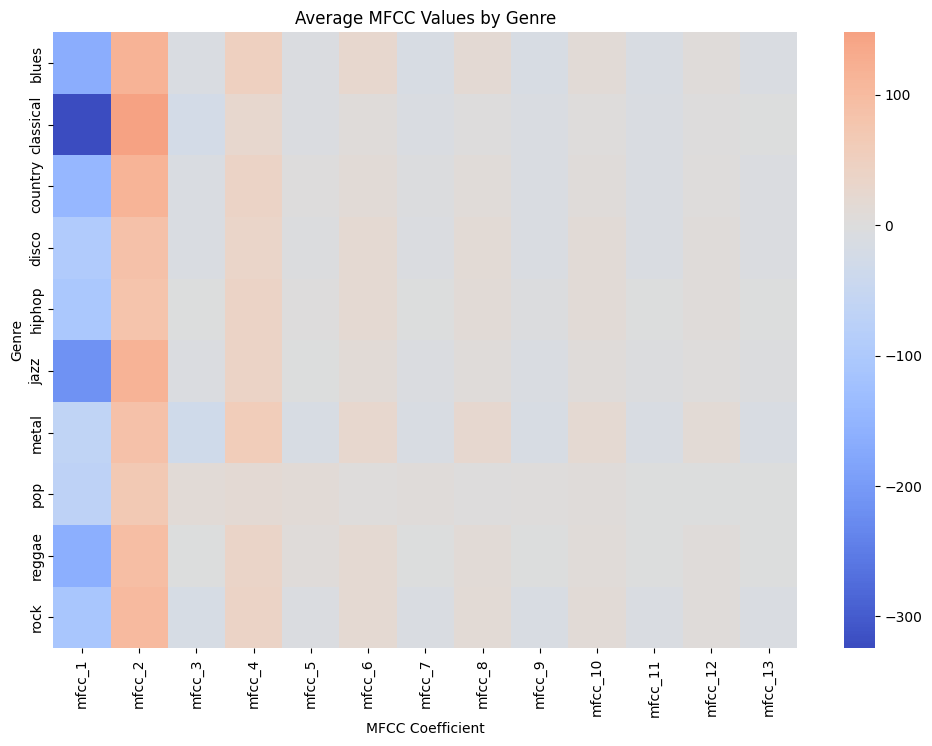

In [22]:
# genereate mfcc columns
mfcc_cols = [f'mfcc_{i}' for i in range(1, 14)]  

# Group by genre and calculate mean MFCCs
mfcc_means = features_df.groupby('genre')[mfcc_cols].mean()

# Visualize as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mfcc_means, cmap='coolwarm', center=0)
plt.title('Average MFCC Values by Genre')
plt.ylabel('Genre')
plt.xlabel('MFCC Coefficient')

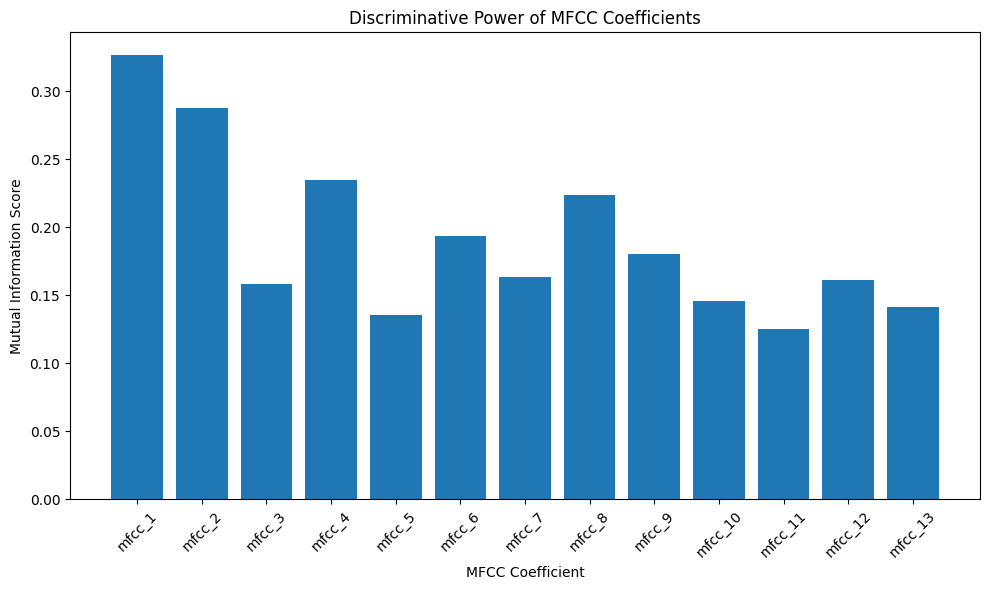

In [23]:
# Let's also look at the discriminative power of each MFCC
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information scores
mi_scores = mutual_info_classif(features_df[mfcc_cols], features_df['genre'])

# Create a bar plot of MFCC importance
plt.figure(figsize=(10, 6))
plt.bar(mfcc_cols, mi_scores)
plt.title('Discriminative Power of MFCC Coefficients')
plt.xlabel('MFCC Coefficient')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

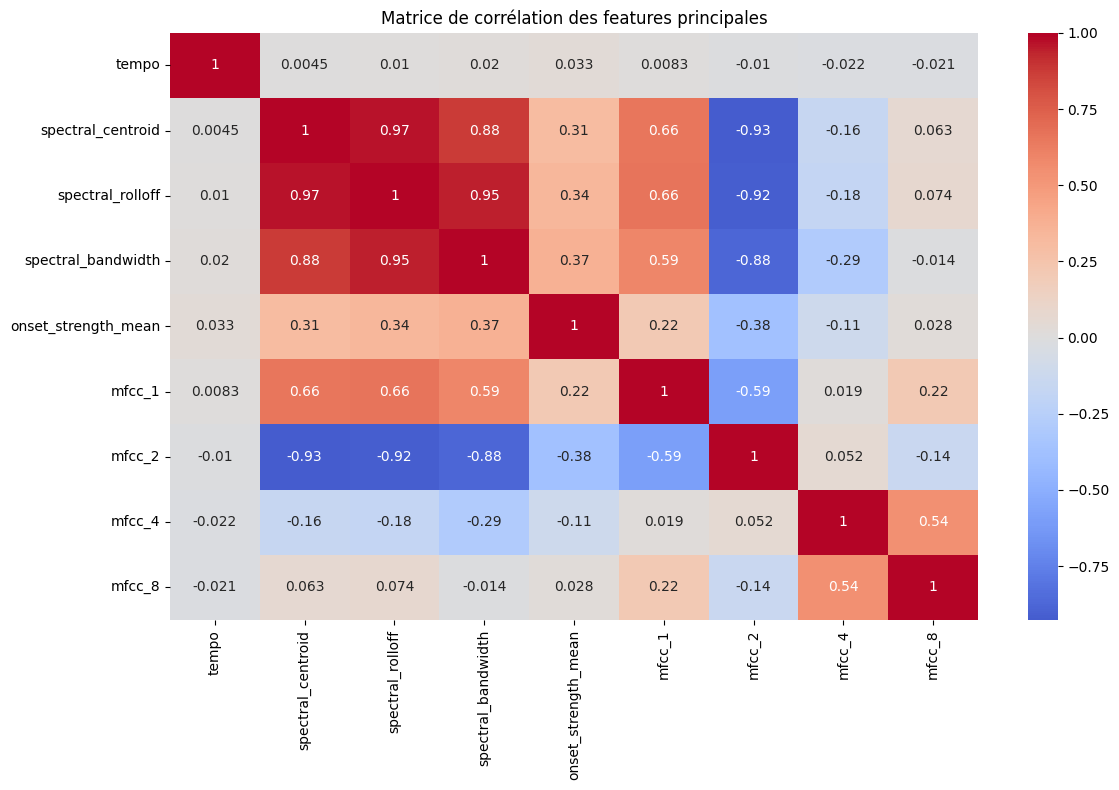

In [24]:
important_features = ['tempo', 'spectral_centroid', 'spectral_rolloff', 
                     'spectral_bandwidth', 'onset_strength_mean', 'mfcc_1', 'mfcc_2', 'mfcc_4', 'mfcc_8']

plt.figure(figsize=(12, 8))
sns.heatmap(features_df_scaled[important_features].corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation des features principales')
plt.tight_layout()
plt.show()

## Dimension Reduction

In [25]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_df_scaled[numeric_features])

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features_df_scaled[numeric_features])

c:\Users\ylfgh\Documents\Python_Projects\MusicClassification2\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ylfgh\Documents\Python_Projects\MusicClassification2\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


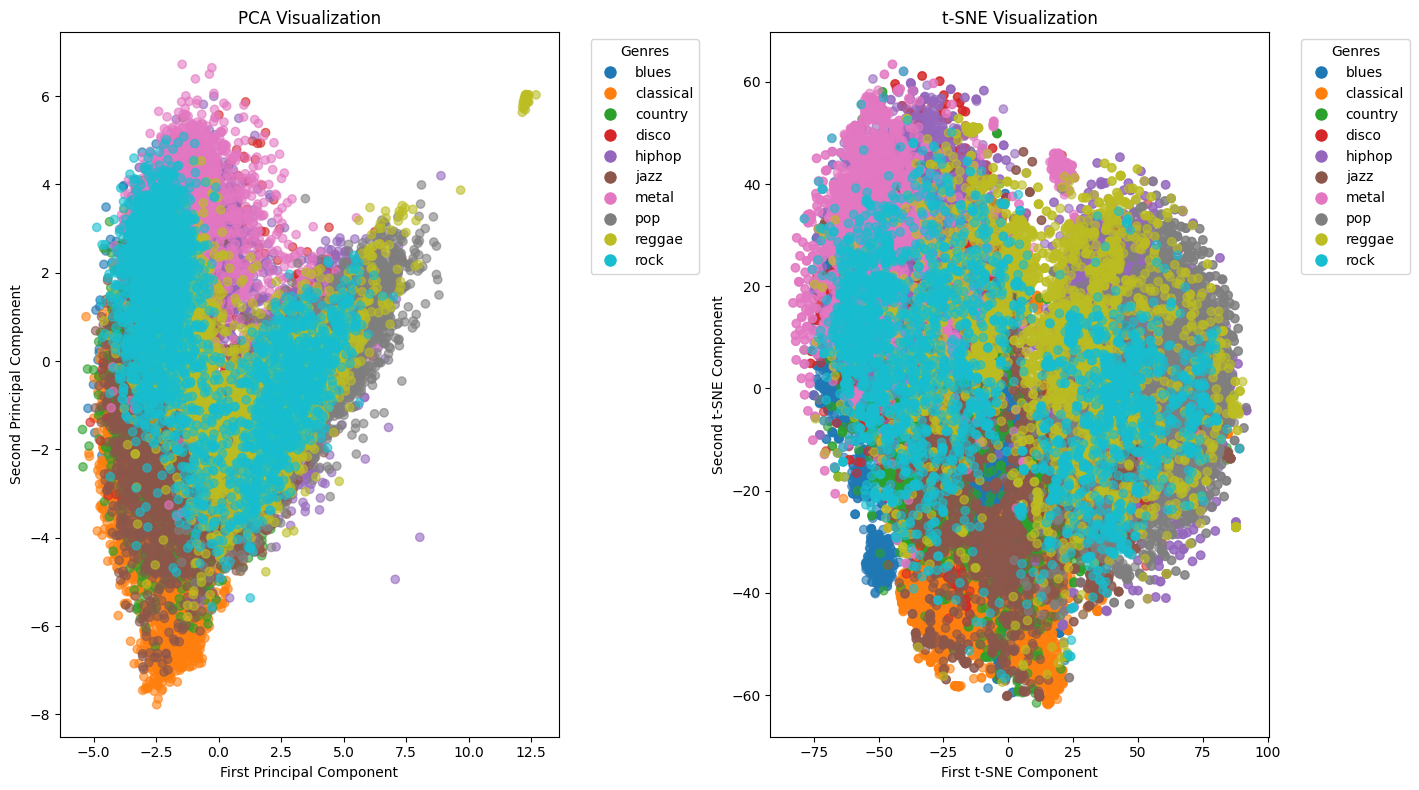

In [26]:
# Create a figure with enough space for the plots and legend
plt.figure(figsize=(20, 8))

# Get unique genres and their color mapping
genres = np.unique(features_df['genre'])
genre_ids = pd.factorize(features_df['genre'])[0]

# Create custom legend elements
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=plt.cm.tab10(i / len(genres)), 
                         label=genre,
                         markersize=10)
                  for i, genre in enumerate(genres)]

# PCA Plot
plt.subplot(131)
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
           c=genre_ids, 
           cmap='tab10', 
           alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(handles=legend_elements, 
          title="Genres", 
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

# t-SNE Plot
plt.subplot(132)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
           c=genre_ids, 
           cmap='tab10', 
           alpha=0.6)
plt.title('t-SNE Visualization')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.legend(handles=legend_elements, 
          title="Genres", 
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

c:\Users\ylfgh\Documents\Python_Projects\MusicClassification2\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ylfgh\Documents\Python_Projects\MusicClassification2\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


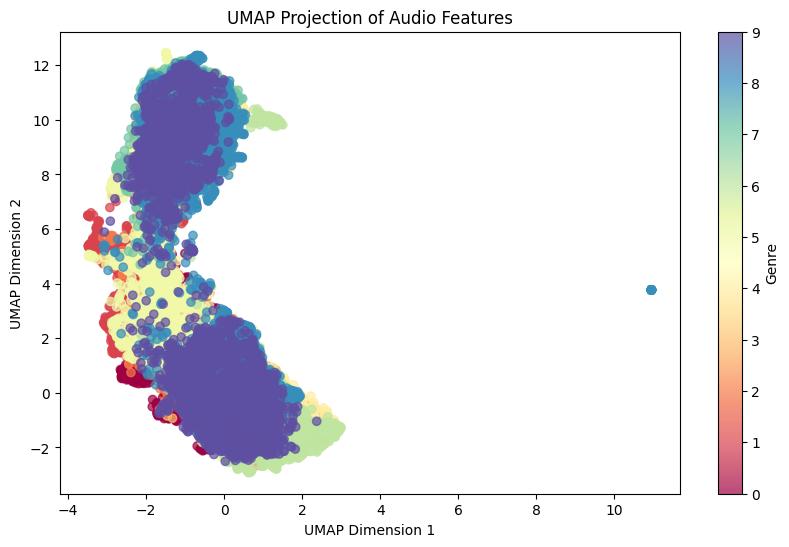

In [31]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(features_df_scaled[numeric_features])

# Plot UMAP results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=pd.factorize(features_df['genre'])[0], cmap='Spectral', alpha=0.7)
plt.colorbar(scatter, label='Genre')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Projection of Audio Features')
plt.show()

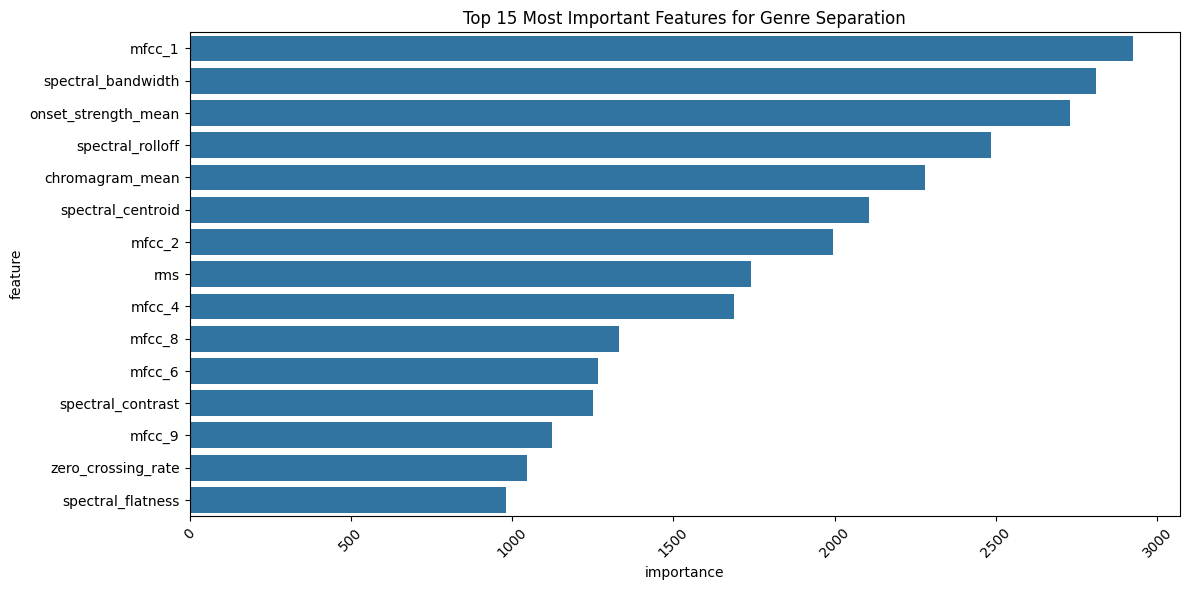

In [33]:
# Prepare the features and target
X = features_df.select_dtypes(include=['float64', 'float32'])  # Numerical features only
y = features_df['genre']

# Use SelectKBest to rank features by their F-scores
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Create a feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': selector.scores_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features for Genre Separation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Based on the feature importance analysis, let's select the top features
# This often improves separation by removing noise from less relevant features
top_features = feature_importance['feature'].head(20).tolist()  # Taking top 20 features

# Create a new DataFrame with only the most important features
X_selected = X[top_features]

# Scale the features using RobustScaler (often better than StandardScaler for audio features)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_selected)

In [35]:
# Let's try a different approach to t-SNE with optimized parameters
# We'll first reduce dimensionality with PCA, then apply t-SNE
# This is a common practice that often yields better results

# First step: PCA to reduce to an intermediate dimension
n_components_pca = 20  
''' 
    n_components must not exceed the smaller of the number of samples (n_samples) 
    or the number of features (n_features). 
    In our case, min(n_samples, n_features) = 20.
'''
pca = PCA(n_components=n_components_pca)
X_pca_intermediate = pca.fit_transform(X_scaled)

# Second step: t-SNE with optimized parameters
tsne_optimized = TSNE(
    n_components=2,
    perplexity=40,  # Increased perplexity for better global structure
    early_exaggeration=12,  # Slightly higher for better separation
    learning_rate=200,  # Adjusted learning rate
    n_iter=2000,  # More iterations for better convergence
    random_state=42
)

X_tsne_optimized = tsne_optimized.fit_transform(X_pca_intermediate)

c:\Users\ylfgh\Documents\Python_Projects\MusicClassification2\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


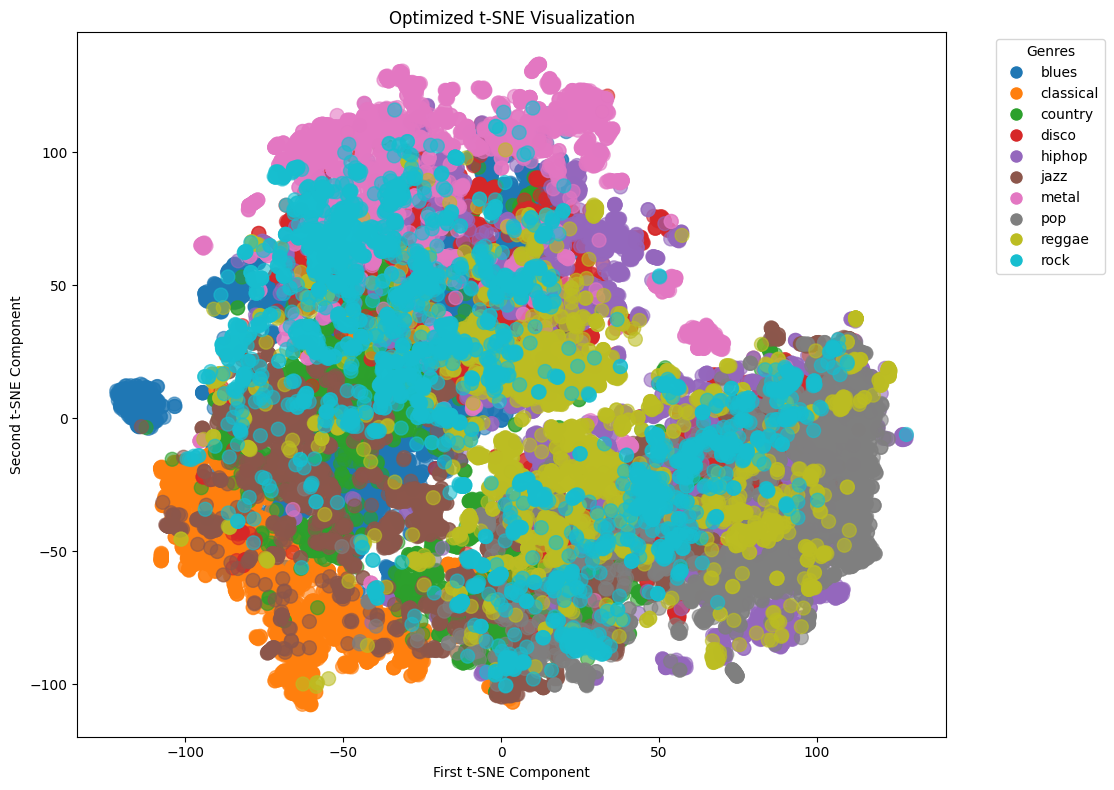

In [36]:
# Create an improved visualization with the optimized results
plt.figure(figsize=(20, 8))

# Create custom legend elements
genres = np.unique(y)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=plt.cm.tab10(i / len(genres)), 
                             label=genre, markersize=10)
                  for i, genre in enumerate(genres)]

# Plot optimized t-SNE results
plt.subplot(121)
scatter = plt.scatter(X_tsne_optimized[:, 0], X_tsne_optimized[:, 1],
                     c=pd.factorize(y)[0],
                     cmap='tab10',
                     alpha=0.6,
                     s=100)  # Increased point size for better visibility

plt.title('Optimized t-SNE Visualization')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.legend(handles=legend_elements,
          title="Genres",
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

plt.tight_layout()
plt.show()

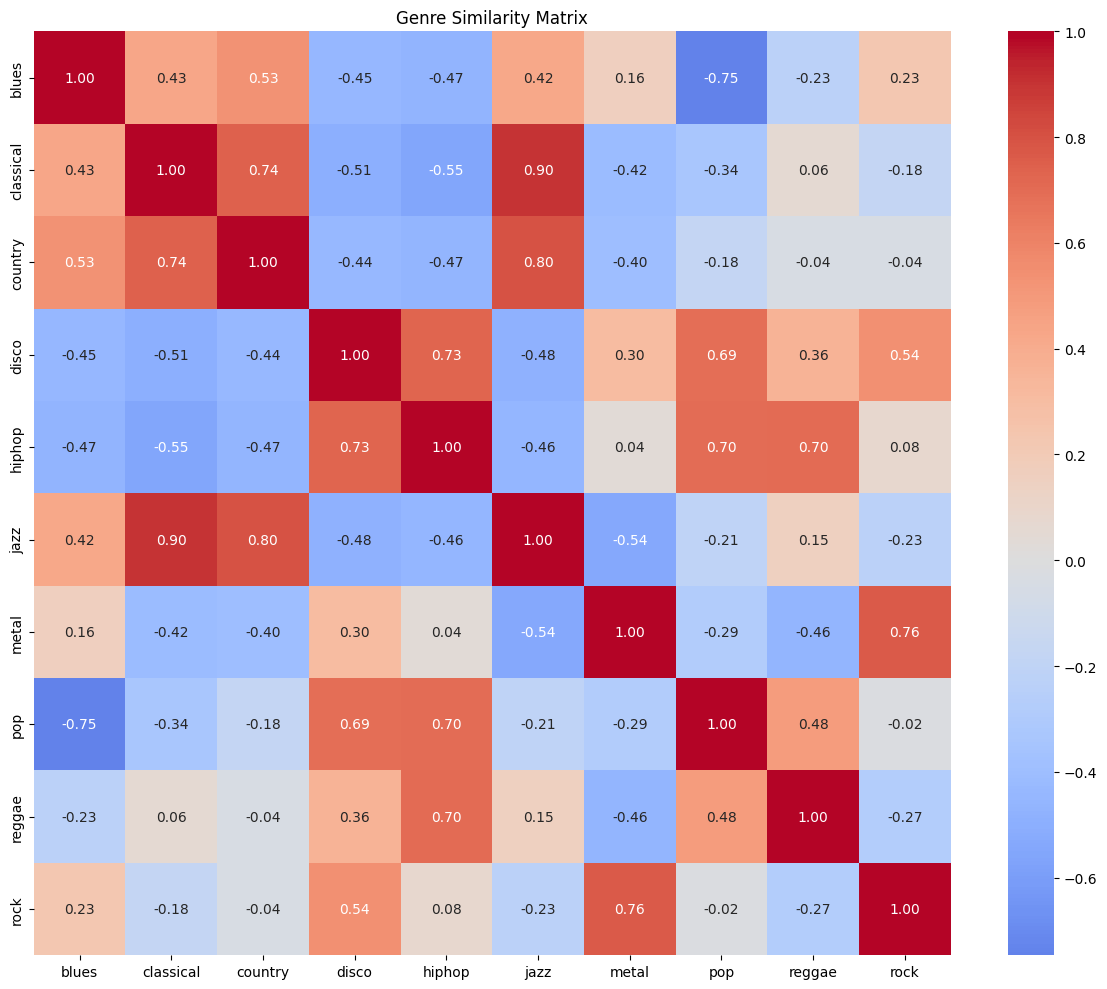

In [37]:
# Let's also examine the separation in feature space using a correlation matrix
# This can help us understand relationships between genres

# Create genre-specific average features
genre_profiles = []
for genre in genres:
    genre_mask = y == genre
    genre_avg = pd.DataFrame(X_scaled[genre_mask]).mean()
    genre_profiles.append(genre_avg)

genre_profiles_df = pd.DataFrame(genre_profiles, index=genres)

# Create and plot correlation matrix between genres
plt.figure(figsize=(12, 10))
sns.heatmap(genre_profiles_df.T.corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Genre Similarity Matrix')
plt.tight_layout()
plt.show()

### Selection the top important features

In [38]:
# let's use the top 8 features
# This often improves separation by removing noise from less relevant features
top_features = feature_importance['feature'].head(8).tolist()  

# Create a new DataFrame with only the most important features
X_selected = X[top_features]

# Scale the features using RobustScaler (often better than StandardScaler for audio features)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_selected)


In [39]:
# save the scaled top features in a csv file
features_df_scaled_top = pd.DataFrame(X_scaled, columns=top_features)
features_df_scaled_top['genre'] = y
features_df_scaled_top.to_csv('music_features_scaled_top.csv', index=False)